# “火炬上的深度学习"第一次大作业

在这个作业中，你需要半独立地利用人工神经网络搭建一个手写数字识别器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [2]:

"""简单的 LeNet-5类型的卷积神经网络模型，MNIST例子.
"""

#所有依赖包

import gzip
import os
import sys

import numpy as np
from six.moves import urllib
import torch
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pylab as plt

#定义一系列常数
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/' #图像数据如果没下载，可以从这个地址下载
WORK_DIRECTORY = 'data' #存储的路径名
IMAGE_SIZE = 28 #每张图片的大小尺寸
NUM_CHANNELS = 1  #每张图片的通道数
PIXEL_DEPTH = 255 #像素的深度0-255
NUM_LABELS = 10 #手写数字，一共十种

%matplotlib inline



# 读取MINST图形文件

In [3]:
#下载图像文件，如果文件已经存在，那么就不下载。
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.isdir(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        size = os.path.getsize(filepath)
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

def extract_data(filename, num_images):
    # filename: 文件存放的路径，num_images: 读入的图片个数
    """将图像解压缩展开，读入成一个4维的张量： [image index（图像的编码）, y（纵坐标）, x（横坐标）, channels（通道）].
    我们将数组中的数值范围从原来的[0, 255]降低到了[-0.5, 0.5]范围内
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return data

def extract_labels(filename, num_images):
    """将label的数据文件解压缩，并将label读成64位的整数"""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

# 将数据解压缩并存储到数组中，60000张图片，60000个label，测试集中有10000张图片
train_data = extract_data(train_data_filename, 60000)
train_X = train_data.reshape(len(train_data), -1)
train_labels = extract_labels(train_labels_filename, 60000)
train_Y = train_labels
test_data = extract_data(test_data_filename, 10000)
test_X = test_data.reshape(len(test_data), -1)

test_labels = extract_labels(test_labels_filename, 10000)
test_Y = test_labels
train_X.shape, train_Y.shape

# train_X, train_Y 中分别存储的是向量化的训练数据与标签
# test_X, test_Y 中分别存储的是向量化的测试数据与标签
# train_X的维度是60000个样本，784个分量的图像向量
# test_X的维度是10000个样本，784个分量的图像向量

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz


((60000, 784), (60000,))

# 在这里写下你自己的代码

### 第一步：定义神经网络，提示，可以使用简单的torch.nn.SequentialModel

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [75]:
# 提示：需要考虑好网络有几层，每一层有多少个节点
net = torch.nn.Sequential(
    torch.nn.Linear(784, 300),
    torch.nn.Sigmoid(),
    torch.nn.Linear(300, 10),
    torch.nn.Sigmoid(),
)

# 问题：如果要增加新的神经网络层怎么办？


### 第二步：构造损失函数和优化器

In [76]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

### 第三步：开始训练循环

In [77]:
# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环
losses = []
# 神经网络训练循环
batch_size = 128
for i in range(1000):
    # 每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取
    batch_loss = []
    # start和end分别是提取一个batch数据的起始和终止下标
    for start in range(0, len(train_X), batch_size):
        end = start + batch_size if start + batch_size < len(train_X) else len(train_X)
        xx = Variable(torch.FloatTensor(train_X[start:end])) #从训练数据train_X中提取数据
        yy = Variable(torch.LongTensor(train_Y[start:end]))  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
        predict = net(xx) #用神经网络进行预测
        loss = cost(predict, yy) #计算损失函数（交叉熵）
        optimizer.zero_grad() #清空梯度
        loss.backward() #开始反向传播
        optimizer.step() #开始更新梯度
        batch_loss.append(loss.data.numpy())
    
    # 每隔100步输出一下损失值（loss）
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 2.23686
100 1.5372
200 1.51618
300 1.50515
400 1.49764
500 1.49227
600 1.48829
700 1.48515
800 1.48256
900 1.48044


### 请在这里写下你自己的回答

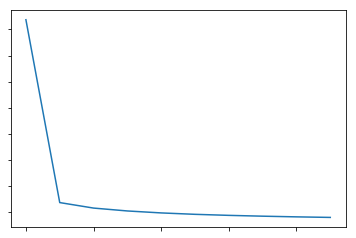

In [78]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！
plt.plot(np.arange(len(losses))*100,losses)


### 第四步：在测试集上测试模型

In [53]:
# 定义一个专门计算分类错误率的函数，它的基本思想是，对于预测向量predictions的每一行，
# 取最大的那个元素的下标，与标签labels中的元素做比较
def error_rate(predictions, labels):
#    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案"""
    predictions = np.argmax(predictions, 1)
    return 100.0 - (
      100.0 *
      np.sum( predictions == labels) /
      predictions.shape[0])

In [79]:
# 分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
    end1 = start + batch_size if start + batch_size < len(test_X) else len(test_X)
    i += 1
    x = Variable(torch.FloatTensor(test_X[start:end]))
    y = Variable(torch.LongTensor(test_Y[start:end]))
    predictions = net(x)
    loss = cost(predictions, y)
    err_rate = error_rate(predictions.data.numpy(), y.data.numpy())
    errors.append(err_rate)
    losses.append(loss.data.numpy())
    print(i, err_rate)

print('平均错误率：%.4f%%'%np.mean(errors))

1 2.61
2 2.63371150729
3 2.64778325123
4 2.64143094842
5 2.63490725126
6 2.64957264957
7 2.63214904679
8 2.65817223199
9 2.62923351159
10 2.61075949367
11 2.56880733945
12 2.51396648045
13 2.48109640832
14 2.48320537428
15 2.44883040936
16 2.46287128713
17 2.36418511066
18 2.31339468303
19 2.24792099792
20 2.20665961945
21 2.21774193548
22 2.21553610503
23 2.21325167038
24 2.15419501134
25 2.10739030023
26 2.10294117647
27 2.12829736211
28 2.13936430318
29 2.0885286783
30 2.11513994911
31 1.98051948052
32 1.90649867374
33 1.84620596206
34 1.74861495845
35 1.69971671388
36 1.66666666667
37 1.61350148368
38 1.59574468085
39 1.53816199377
40 1.45766773163
41 1.49590163934
42 1.49410774411
43 1.51384083045
44 1.5346975089
45 1.55677655678
46 1.50943396226
47 1.48346303502
48 1.38052208835
49 1.34854771784
50 1.34120171674
51 1.38888888889
52 1.41129032258
53 1.25598086124
54 1.27487562189
55 1.29533678756
56 1.35135135135
57 1.41242937853
58 1.44230769231
59 1.51397515528
60 1.5114379085
6

### 用单个图像进行测试

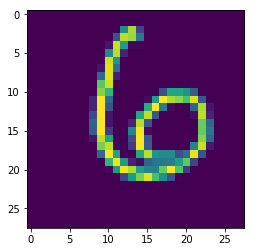

In [55]:
#随便从数据集中读入一张图片，并绘制出来
idx = 100
muteimg = test_data[idx, 0, :, :]
plt.imshow(muteimg)

In [56]:
# 计算识别结果
x = Variable(torch.FloatTensor(test_X[idx, :].reshape(1, -1)))
predict = net(x)
np.argmax(predict.data.numpy())

6

## 升级版

如果你已经运行跑通上面的所有代码，那么请你尝试对其进行更改，让测试集上面的识别错误率进一步下降，看看能不能到1%以下

提示：可以考虑增加层的深度

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码